<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/TMS_fMRI_ANN_Effect_Comparison_tplus1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/TMS_fMRI_ANN_Effect_Comparison_tplus1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare empirical vs ANN stimulation effects (TMS-fMRI)

Loads `stim_effects_ann_vs_emp.pkl` and for each stimulation **target parcel** computes:
- Mean empirical effect at t+1: `emp_t1 - pre_window[-1]`
- Mean ANN effect at t+1: `pred_stim_t1 - pred_base_t1`

Then correlates these mean effect vectors per target and evaluates significance with a permutation null.


In [1]:

# =========================
# 0) Mount Google Drive
# =========================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

# =========================
# 1) Imports + paths
# =========================
import os, pickle, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
PREPROC_ROOT = os.path.join(BASE, "preprocessed_subjects_tms_fmri")
IN_DIR = os.path.join(PREPROC_ROOT, "ANN_vs_tms_fmri")

IN_PKL = os.path.join(IN_DIR, "stim_effects_ann_vs_emp.pkl")
if not os.path.exists(IN_PKL):
    raise FileNotFoundError(f"Cannot find {IN_PKL}. Did you run TMS_fMRI_ANN.ipynb?")

OUT_DIR = os.path.join(IN_DIR, "effect_comparison_tplus1")
FIG_DIR = os.path.join(OUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

print("Loading:", IN_PKL)
with open(IN_PKL, "rb") as f:
    stim_effects = pickle.load(f)

print("Subjects in stim_effects:", len(stim_effects))


Loading: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/stim_effects_ann_vs_emp.pkl
Subjects in stim_effects: 46


In [24]:

# =========================
# 2) Config
# =========================
N = 450                 # parcels
N_PERM = 1000           # permutations for null distribution per target
RANDOM_SEED = 0
TPLUS = 1               # t+1 here; can switch to 2 later if pred_*_t2 was saved
SAVE_TOP_K_PLOTS = 11   # how many target plots to save (sorted by p-value)

rng = np.random.default_rng(RANDOM_SEED)


In [25]:

# =========================
# 3) Aggregate mean effects per target
# =========================
mean_emp = {}
mean_ann = {}
counts = {}

def get_emp_post(ev, tplus=1):
    if tplus == 1: return ev["emp_t1"]
    if tplus == 2: return ev["emp_t2"]
    if tplus == 3: return ev["emp_t3"]
    raise ValueError("tplus must be 1,2,3")

for sub_id, targets in stim_effects.items():
    for target_idx, events in targets.items():
        for ev in events:
            x_t = ev["pre_window"][-1]               # (N,)
            x_post = get_emp_post(ev, tplus=2)   # (N,) #TPLUS
            eff_emp = x_post - x_t

            if TPLUS == 1:
                eff_ann = ev["pred_stim_t1"] - ev["pred_base_t1"]
            elif TPLUS == 2:
                if "pred_stim_t2" not in ev:
                    continue
                eff_ann = ev["pred_stim_t2"] - ev["pred_base_t2"]
            else:
                # no ANN t+3 saved in the upstream notebook
                continue

            if target_idx not in mean_emp:
                mean_emp[target_idx] = np.zeros(N, dtype=np.float64)
                mean_ann[target_idx] = np.zeros(N, dtype=np.float64)
                counts[target_idx] = 0

            mean_emp[target_idx] += eff_emp
            mean_ann[target_idx] += eff_ann
            counts[target_idx] += 1

for t in list(mean_emp.keys()):
    c = counts[t]
    if c <= 0:
        del mean_emp[t]; del mean_ann[t]; del counts[t]
    else:
        mean_emp[t] /= c
        mean_ann[t] /= c

print("Targets with data:", len(mean_emp))
print("Example (target -> count):", list(counts.items())[:5])


Targets with data: 11
Example (target -> count): [(401, 3060), (342, 2788), (359, 2924), (403, 2992), (305, 2924)]


In [26]:
n=400
# =========================
# 4) Correlation + permutation null per target
# =========================
def pearsonr_fast(x, y):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    x = x - x.mean()
    y = y - y.mean()
    denom = np.sqrt(np.sum(x*x) * np.sum(y*y))
    if denom == 0:
        return np.nan
    return float(np.sum(x*y) / denom)

results = []

for target_idx in sorted(mean_emp.keys()):
    emp = mean_emp[target_idx][-n:]
    ann = mean_ann[target_idx][-n:]

    r_obs = pearsonr_fast(emp, ann)

    r_null = np.empty(N_PERM, dtype=np.float64)
    for i in range(N_PERM):
        perm = rng.permutation(n)
        r_null[i] = pearsonr_fast(emp, ann[perm])

    p = (np.sum(np.abs(r_null) >= abs(r_obs)) + 1) / (N_PERM + 1)

    results.append({
        "target_idx": int(target_idx),
        "n_events": int(counts[target_idx]),
        "r_emp_vs_ann": r_obs,
        "p_perm_two_sided": p,
        "null_mean": float(np.mean(r_null)),
        "null_std": float(np.std(r_null)),
    })

res_df = pd.DataFrame(results).sort_values("p_perm_two_sided").reset_index(drop=True)
res_df.head(10)


,target_idx,n_events,r_emp_vs_ann,p_perm_two_sided,null_mean,null_std
0,403,2992,0.161389,0.000999,0.002885,0.049352
1,401,3060,0.147845,0.003996,-0.000804,0.050885
2,305,2924,0.125298,0.010989,0.000177,0.049678
3,342,2788,0.126937,0.019980,-0.002999,0.052575
4,386,2040,-0.103760,0.045954,-0.000166,0.049436
5,366,2516,-0.094663,0.068931,-0.000822,0.050511
6,231,2992,0.075969,0.121878,-0.000467,0.049637
7,155,2856,0.047124,0.354645,-0.002201,0.050108
8,359,2924,0.040063,0.441558,-0.004047,0.050787
9,220,1904,0.025269,0.627373,0.000289,0.049112


In [27]:
# =========================
# 5) Save mean dictionaries + summary table
# =========================
out_emp = os.path.join(OUT_DIR, f"mean_emp_effect_tplus{TPLUS}.pkl")
out_ann = os.path.join(OUT_DIR, f"mean_ann_effect_tplus{TPLUS}.pkl")
out_csv = os.path.join(OUT_DIR, f"corr_summary_tplus{TPLUS}.csv")

with open(out_emp, "wb") as f:
    pickle.dump(mean_emp, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(out_ann, "wb") as f:
    pickle.dump(mean_ann, f, protocol=pickle.HIGHEST_PROTOCOL)

res_df.to_csv(out_csv, index=False)

cfg = {
    "tplus": TPLUS,
    "N": N,
    "N_PERM": N_PERM,
    "random_seed": RANDOM_SEED,
    "emp_effect": "emp_tplus - pre_window[-1]",
    "ann_effect": "pred_stim_tplus - pred_base_tplus",
    "input_file": IN_PKL,
    "out_dir": OUT_DIR
}
with open(os.path.join(OUT_DIR, "config.json"), "w") as f:
    json.dump(cfg, f, indent=2)

print("Saved:", out_emp)
print("Saved:", out_ann)
print("Saved:", out_csv)


Saved: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/effect_comparison_tplus1/mean_emp_effect_tplus1.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/effect_comparison_tplus1/mean_ann_effect_tplus1.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/effect_comparison_tplus1/corr_summary_tplus1.csv


In [20]:
# =========================
# 6) Plot per-target scatter with regression line
# =========================
def plot_scatter_with_fit(x, y, title, out_path):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    a, b = np.polyfit(x, y, 1)

    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=8, alpha=0.7)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, a*xs + b, linewidth=2)
    plt.xlabel(f"Mean empirical effect (t+{TPLUS})")
    plt.ylabel(f"Mean ANN effect (t+{TPLUS})")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()

TOP_K = int(SAVE_TOP_K_PLOTS)
for _, row in res_df.head(TOP_K).iterrows():
    t = int(row["target_idx"])
    r = row["r_emp_vs_ann"]
    p = row["p_perm_two_sided"]
    n = int(row["n_events"])
    title = f"Target {t} | n={n} | r={r:.3f} | p_perm={p:.4g}"
    out_png = os.path.join(FIG_DIR, f"target_{t:03d}_scatter.png")
    plot_scatter_with_fit(mean_emp[t], mean_ann[t], title, out_png)

print(f"Saved scatter plots for TOP_K={TOP_K} targets into:", FIG_DIR)


Saved scatter plots for TOP_K=11 targets into: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/effect_comparison_tplus1/figures


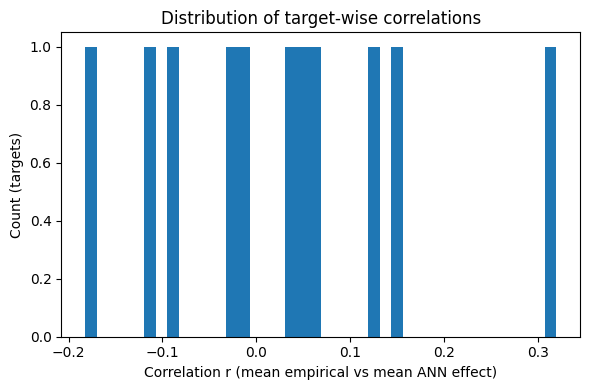

In [21]:

# =========================
# 7) Quick view: histogram of correlations
# =========================
plt.figure(figsize=(6, 4))
plt.hist(res_df["r_emp_vs_ann"].dropna().values, bins=40)
plt.xlabel("Correlation r (mean empirical vs mean ANN effect)")
plt.ylabel("Count (targets)")
plt.title("Distribution of target-wise correlations")
plt.tight_layout()
plt.show()
